In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from gurobipy import Model, GRB, quicksum
GUROBI_OUTPUT = 1

In [50]:
WORKING_DIR = "/Users/junyangwu/Junyang Wu/Study/Columbia/2025.9-2025.12/4004 Optimization model and methods/Group Study/Project 2"

In [51]:
df = pd.read_csv(f'{WORKING_DIR}/games.csv')
df

,Date,Visitor,PTS,Home,PTS.1,Attend.,LOG,Arena,Notes
0,"Sat, Nov 01, 2025",Golden State Warriors,NaN,Boston Celtics,NaN,"19,000",7:30 PM,TD Garden,NaN
1,"Sat, Nov 01, 2025",Los Angeles Lakers,NaN,New York Knicks,NaN,"19,400",7:30 PM,Madison Square Garden,NaN
2,"Sat, Nov 01, 2025",Denver Nuggets,NaN,Brooklyn Nets,NaN,"17,500",7:30 PM,Barclays Center,NaN
3,"Sat, Nov 01, 2025",Phoenix Suns,NaN,Philadelphia 76ers,NaN,"19,650",7:30 PM,Wells Fargo Center,NaN
4,"Sat, Nov 01, 2025",Houston Rockets,NaN,Toronto Raptors,NaN,"19,600",7:30 PM,Scotiabank Arena,NaN
...,...,...,...,...,...,...,...,...,...
123,"Thu, Dec 25, 2025",Philadelphia 76ers,NaN,Phoenix Suns,NaN,"17,450",7:30 PM,Footprint Center,Christmas Day
124,"Thu, Dec 25, 2025",Toronto Raptors,NaN,Houston Rockets,NaN,"17,800",7:30 PM,Toyota Center,Christmas Day
125,"Thu, Dec 25, 2025",Miami Heat,NaN,Dallas Mavericks,NaN,"19,800",7:30 PM,American Airlines Center,Christmas Day
126,"Thu, Dec 25, 2025",Chicago Bulls,NaN,Atlanta Hawks,NaN,"17,250",7:30 PM,State Farm Arena,Christmas Day


In [52]:
teams = df['Home'].unique().tolist()
teams.sort()
teams

['Atlanta Hawks',
 'Boston Celtics',
 'Brooklyn Nets',
 'Chicago Bulls',
 'Cleveland Cavaliers',
 'Dallas Mavericks',
 'Denver Nuggets',
 'Golden State Warriors',
 'Houston Rockets',
 'Los Angeles Lakers',
 'Miami Heat',
 'Milwaukee Bucks',
 'New York Knicks',
 'Philadelphia 76ers',
 'Phoenix Suns',
 'Toronto Raptors']

# Question 1

In [53]:
df = df.rename(columns={"Date": "date","Visitor": "visitor","Home": "home",})
df = df[["date", "visitor", "home"]].copy()

df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")
df["date_final"] = df["date_parsed"].dt.date.astype("string")
null_mask = df["date_parsed"].isna()
df.loc[null_mask, "date_final"] = df.loc[null_mask, "date"]

## (a)

In [54]:
home_dates_series = (df.groupby("home")["date_final"].agg(list).sort_index())
home_dates_df = (home_dates_series.apply(lambda x: ", ".join([d for d in x if isinstance(d, str)])).reset_index().rename(columns={"home": "team", "date_final": "home_dates"}))
home_dates_df

,team,home_dates
0,Atlanta Hawks,"2025-11-03, 2025-11-07, 2025-11-15, 2025-11-17..."
1,Boston Celtics,"2025-11-01, 2025-11-07, 2025-11-13, 2025-11-19..."
2,Brooklyn Nets,"2025-11-01, 2025-11-05, 2025-11-11, 2025-11-13..."
3,Chicago Bulls,"2025-11-01, 2025-11-03, 2025-11-13, 2025-11-21..."
4,Cleveland Cavaliers,"2025-11-03, 2025-11-07, 2025-11-17, 2025-11-19..."
5,Dallas Mavericks,"2025-11-03, 2025-11-07, 2025-11-15, 2025-11-17..."
6,Denver Nuggets,"2025-11-05, 2025-11-07, 2025-11-11, 2025-11-15..."
7,Golden State Warriors,"2025-11-03, 2025-11-05, 2025-11-11, 2025-11-15..."
8,Houston Rockets,"2025-11-03, 2025-11-11, 2025-11-13, 2025-11-15..."
9,Los Angeles Lakers,"2025-11-03, 2025-11-05, 2025-11-11, 2025-11-15..."


## (b)

In [55]:
home_vs_counts = pd.crosstab(index=df["home"], columns=df["visitor"]).sort_index().sort_index(axis=1)
home_vs_counts

visitor,Atlanta Hawks,Boston Celtics,Brooklyn Nets,Chicago Bulls,Cleveland Cavaliers,Dallas Mavericks,Denver Nuggets,Golden State Warriors,Houston Rockets,Los Angeles Lakers,Miami Heat,Milwaukee Bucks,New York Knicks,Philadelphia 76ers,Phoenix Suns,Toronto Raptors
home,,,,,,,,,,,,,,,,
Atlanta Hawks,0,1,0,1,0,1,0,1,0,1,1,1,1,0,1,1
Boston Celtics,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1,0
Brooklyn Nets,1,1,0,0,0,1,1,1,0,0,1,0,0,1,0,0
Chicago Bulls,1,1,1,0,0,0,1,1,1,1,0,1,0,0,0,1
Cleveland Cavaliers,1,1,1,1,0,0,1,0,1,0,1,1,1,0,0,1
Dallas Mavericks,0,0,0,1,1,0,1,1,1,1,1,0,0,1,0,1
Denver Nuggets,1,1,1,0,0,0,0,0,1,1,1,0,1,1,0,0
Golden State Warriors,0,1,0,0,1,0,1,0,1,0,0,1,1,1,0,0
Houston Rockets,1,1,1,0,0,0,0,0,0,1,0,1,1,1,1,1


!todo Heatmap

## (c)

In [56]:
away_vs_counts = pd.crosstab(index=df["visitor"], columns=df["home"]).sort_index().sort_index(axis=1)
away_vs_counts

home,Atlanta Hawks,Boston Celtics,Brooklyn Nets,Chicago Bulls,Cleveland Cavaliers,Dallas Mavericks,Denver Nuggets,Golden State Warriors,Houston Rockets,Los Angeles Lakers,Miami Heat,Milwaukee Bucks,New York Knicks,Philadelphia 76ers,Phoenix Suns,Toronto Raptors
visitor,,,,,,,,,,,,,,,,
Atlanta Hawks,0,0,1,1,1,0,1,0,1,0,0,0,0,1,0,0
Boston Celtics,1,0,1,1,1,0,1,1,1,1,0,0,1,0,0,1
Brooklyn Nets,0,0,0,1,1,0,1,0,1,1,0,1,1,0,1,1
Chicago Bulls,1,0,0,0,1,1,0,0,0,0,1,0,1,1,1,0
Cleveland Cavaliers,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0
Dallas Mavericks,1,1,1,0,0,0,0,0,0,0,1,1,1,0,1,0
Denver Nuggets,0,0,1,1,1,1,0,1,0,0,0,1,0,0,1,1
Golden State Warriors,1,1,1,1,0,1,0,0,0,1,1,0,0,0,1,1
Houston Rockets,0,0,0,1,1,1,1,1,0,0,1,0,0,0,0,1


## (d)

In [57]:
away_dates_series = (df.groupby("visitor")["date_final"].agg(list).sort_index())
away_dates_df = (away_dates_series.apply(lambda x: ", ".join([d for d in x if isinstance(d, str)])).reset_index().rename(columns={"visitor": "team", "date_final": "away_dates"}))
away_dates_df

,team,away_dates
0,Atlanta Hawks,"2025-11-01, 2025-11-05, 2025-11-11, 2025-11-13..."
1,Boston Celtics,"2025-11-03, 2025-11-05, 2025-11-11, 2025-11-15..."
2,Brooklyn Nets,"2025-11-03, 2025-11-07, 2025-11-15, 2025-11-17..."
3,Chicago Bulls,"2025-11-05, 2025-11-07, 2025-11-11, 2025-11-15..."
4,Cleveland Cavaliers,"2025-11-01, 2025-11-05, 2025-11-11, 2025-11-13..."
5,Dallas Mavericks,"2025-11-01, 2025-11-05, 2025-11-11, 2025-11-13..."
6,Denver Nuggets,"2025-11-01, 2025-11-03, 2025-11-13, 2025-11-23..."
7,Golden State Warriors,"2025-11-01, 2025-11-07, 2025-11-13, 2025-11-19..."
8,Houston Rockets,"2025-11-01, 2025-11-05, 2025-11-07, 2025-11-17..."
9,Los Angeles Lakers,"2025-11-01, 2025-11-07, 2025-11-13, 2025-11-21..."


In [58]:
export_path = f"{WORKING_DIR}/export_data/output_summary.xlsx"
with pd.ExcelWriter(export_path, engine="openpyxl") as writer:
    home_dates_df.to_excel(writer, sheet_name="(a)home_dates", index=False)
    home_vs_counts.to_excel(writer, sheet_name="(b)home_vs_counts")
    away_vs_counts.to_excel(writer, sheet_name="(c)away_vs_counts")
    away_dates_df.to_excel(writer, sheet_name="(d)away_dates", index=False)

# Question 2

Notations:

- Set of teams: $T$
- Set of dates: $D$

For each team $i \in T$:

- $H_i \subseteq D$: dates on which team $i$ must play **at home**
- $A_i \subseteq D$: dates on which team $i$ must play **away**

Parameters:

- $h_{i,t} = 1$ if $t \in H_i$, $0$ otherwise  
- $a_{i,t} = 1$ if $t \in A_i$, $0$ otherwise  
- $b_{ij}$: number of times team $i$ plays home vs. team $j$  
- $c_{ij}$: number of times team $i$ plays away vs. team $j$ (at $j$'s home)

Decision variable

$$
x_{ijt} =
\begin{cases}
1, & \text{if team } i \text{ plays at home against } j \text{ on date } t, \\
0, & \text{otherwise}
\end{cases}
\qquad (i \neq j,\; t \in D)
$$


## (e)
For every team $i$ and every date $t$, team $i$ plays at home on date $t$ if and only if
$t$ is one of its home dates $H_i$:

$$
\sum_{j \in T,\, j \neq i} x_{ijt} = h_{i,t}
\qquad \forall i \in T,\; \forall t \in D.
$$

---

## (f)

For every team $i$ and every date $t$, team $i$ plays away on date $t$ if and only if
$t$ is one of its away dates $A_i$. Being away means it is the visiting team in some
home game of another team:

$$
\sum_{j \in T,\, j \neq i} x_{jit} = a_{i,t}
\qquad \forall i \in T,\; \forall t \in D.
$$

---

## (g)

For every ordered pair of distinct teams $(i,j)$, the total number of home games
where $i$ hosts $j$ must equal $b_{ij}$:

$$
\sum_{t \in D} x_{ijt} = b_{ij}
\qquad \forall i,j \in T,\; i \neq j.
$$

---

## (h)

For every ordered pair of distinct teams $(i,j)$, the total number of away games
where $i$ visits $j$ (i.e., $j$ is at home versus $i$) must equal $c_{ij}$

$$
\sum_{t \in D} x_{jit} = c_{ij}
\qquad \forall i,j \in T,\; i \neq j.
$$


In [59]:
df = pd.read_csv(f'{WORKING_DIR}/games.csv')

df = df.rename(columns={
    "Date": "date",
    "Visitor": "visitor",
    "Home": "home",
    "Arena": "arena"
})

df = df[["date", "visitor", "home", "arena"]].copy()

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["date_str"] = df["date"].dt.strftime("%Y-%m-%d")

teams = sorted(pd.unique(pd.concat([df["visitor"], df["home"]], ignore_index=True)))
dates = sorted(df["date_str"].unique().tolist())

print("Teams:", teams)
print("Total teams:", len(teams))
print("Total dates:", len(dates))

Teams: ['Atlanta Hawks', 'Boston Celtics', 'Brooklyn Nets', 'Chicago Bulls', 'Cleveland Cavaliers', 'Dallas Mavericks', 'Denver Nuggets', 'Golden State Warriors', 'Houston Rockets', 'Los Angeles Lakers', 'Miami Heat', 'Milwaukee Bucks', 'New York Knicks', 'Philadelphia 76ers', 'Phoenix Suns', 'Toronto Raptors']
Total teams: 16
Total dates: 16


In [60]:
home_dates = (df.groupby("home")["date_str"].agg(list).to_dict())
for t in teams:
    home_dates.setdefault(t, [])

away_dates = (df.groupby("visitor")["date_str"].agg(list).to_dict())
for t in teams:
    away_dates.setdefault(t, [])

print("\nExample home_dates['Boston Celtics']:", home_dates.get("Boston Celtics", []))
print("Example away_dates['Boston Celtics']:", away_dates.get("Boston Celtics", []))


Example home_dates['Boston Celtics']: ['2025-11-01', '2025-11-07', '2025-11-13', '2025-11-19', '2025-11-23', '2025-11-28']
Example away_dates['Boston Celtics']: ['2025-11-03', '2025-11-05', '2025-11-11', '2025-11-15', '2025-11-17', '2025-11-21', '2025-11-27', '2025-11-29', '2025-12-01', '2025-12-25']


In [61]:
home_vs = pd.crosstab(index=df["home"], columns=df["visitor"]).reindex(index=teams, columns=teams, fill_value=0)
away_vs = pd.crosstab(index=df["visitor"], columns=df["home"]).reindex(index=teams, columns=teams, fill_value=0)

b = {(i, j): int(home_vs.loc[i, j]) for i in teams for j in teams}
c = {(i, j): int(away_vs.loc[i, j]) for i in teams for j in teams}

print("\nSample b_ij (home_vs counts) for 'Boston Celtics':")
print(home_vs.loc["Boston Celtics"])


Sample b_ij (home_vs counts) for 'Boston Celtics':
visitor
Atlanta Hawks            0
Boston Celtics           0
Brooklyn Nets            0
Chicago Bulls            0
Cleveland Cavaliers      0
Dallas Mavericks         1
Denver Nuggets           0
Golden State Warriors    1
Houston Rockets          0
Los Angeles Lakers       0
Miami Heat               1
Milwaukee Bucks          1
New York Knicks          0
Philadelphia 76ers       1
Phoenix Suns             1
Toronto Raptors          0
Name: Boston Celtics, dtype: int64


In [62]:

team_timezone = {
    "Boston Celtics": 0,
    "New York Knicks": 0,
    "Brooklyn Nets": 0,
    "Philadelphia 76ers": 0,
    "Toronto Raptors": 0,
    "Miami Heat": 0,
    "Chicago Bulls": -1,
    "Milwaukee Bucks": -1,
    "Los Angeles Lakers": -3,
    "Golden State Warriors": -3,
    "Phoenix Suns": -2,
    "Houston Rockets": -1,
    "Dallas Mavericks": -1,
    "Atlanta Hawks": 0,
    "Cleveland Cavaliers": 0,
    "Denver Nuggets": -2
}

In [63]:
m = Model("NBA_schedule_with_timezone")
m.Params.OutputFlag = 1

x = {}
for i in teams:
    for d in home_dates[i]:
        for j in teams:
            if i == j:
                continue
            x[(i, j, d)] = m.addVar(vtype=GRB.BINARY,
                                    name=f"x[{i},{j},{d}]")

m.update()

for i in teams:
    for d in home_dates[i]:
        m.addConstr(
            quicksum(x[(i, j, d)] for j in teams if j != i) == 1,
            name=f"home_one[{i},{d}]"
        )

for i in teams:
    for d in away_dates[i]:
        m.addConstr(
            quicksum(
                x[(j, i, d)] for j in teams
                if j != i and (j, i, d) in x
            ) == 1,
            name=f"away_one[{i},{d}]"
        )

for i in teams:
    for j in teams:
        if i == j:
            continue
        m.addConstr(
            quicksum(
                x[(i, j, d)]
                for d in home_dates[i]
                if (i, j, d) in x
            ) == b[(i, j)],
            name=f"pair_home[{i},{j}]"
        )

for i in teams:
    for j in teams:
        if i == j:
            continue
        m.addConstr(
            quicksum(
                x[(j, i, d)]
                for d in away_dates[i]
                if (j, i, d) in x
            ) == c[(i, j)],
            name=f"pair_away[{i},{j}]"
        )

m.update()
m.setObjective(0.0, GRB.MINIMIZE)
m.optimize()

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B2082)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 736 rows, 1920 columns and 5888 nonzeros
Model fingerprint: 0x038de529
Variable types: 0 continuous, 1920 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 428 rows and 1478 columns
Presolve time: 0.00s
Presolved: 308 rows, 442 columns, 1386 nonzeros
Variable types: 0 continuous, 442 integer (442 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.00000000000

In [64]:
for d in dates:
    for i in teams:
        if d not in home_dates[i]:
            continue
        for j in teams:
            if i == j:
                continue
            key = (i, j, d)
            if key in x and x[key].X > 0.5:
                schedule_rows.append({
                    "date": d,
                    "home": i,
                    "away": j,
                    "home_tz": team_timezone[i],
                    "away_tz": team_timezone[j]
                })

schedule_df = pd.DataFrame(schedule_rows).sort_values(["date", "home"])
schedule_df

,date,home,away,home_tz,away_tz
0,2025-11-01,Boston Celtics,Phoenix Suns,0,-2
1,2025-11-01,Brooklyn Nets,Atlanta Hawks,0,0
2,2025-11-01,Chicago Bulls,Houston Rockets,-1,-1
3,2025-11-01,Miami Heat,Golden State Warriors,0,-3
4,2025-11-01,Milwaukee Bucks,Dallas Mavericks,-1,-1
...,...,...,...,...,...
123,2025-12-25,Denver Nuggets,Boston Celtics,-2,0
124,2025-12-25,Golden State Warriors,New York Knicks,-3,0
125,2025-12-25,Houston Rockets,Philadelphia 76ers,-1,0
126,2025-12-25,Los Angeles Lakers,Toronto Raptors,-3,0


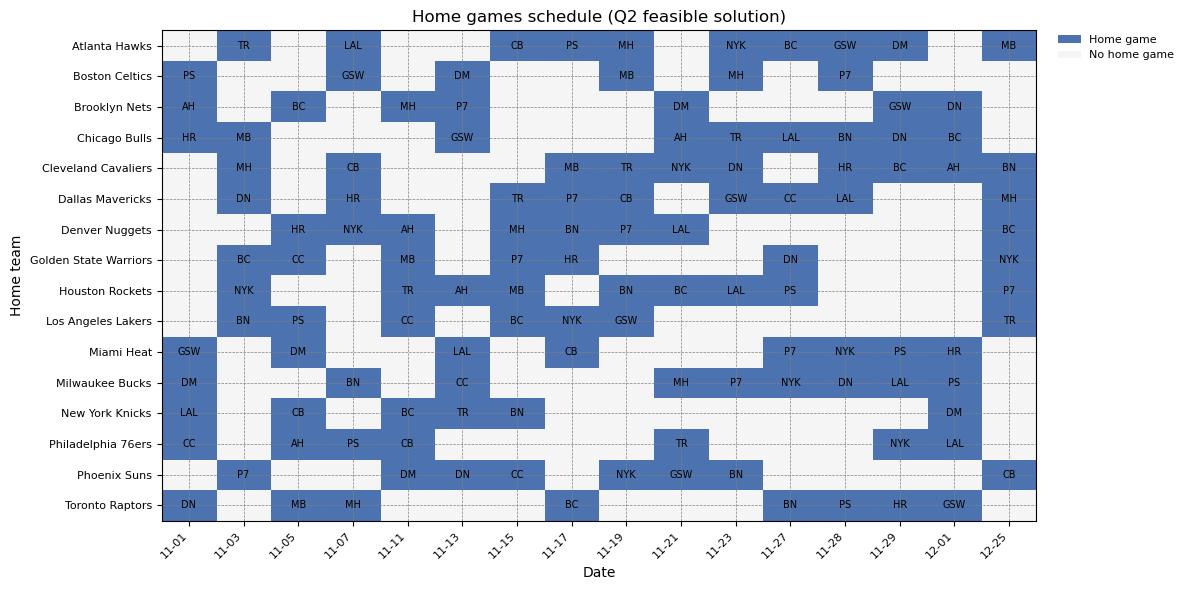

In [65]:
schedule_plot = schedule_df.copy()
schedule_plot["date"] = pd.to_datetime(schedule_plot["date"])
schedule_plot["date_str"] = schedule_plot["date"].dt.strftime("%m-%d")

teams = sorted(schedule_plot["home"].unique())
dates = sorted(schedule_plot["date_str"].unique())

home_matrix = pd.DataFrame(
    0, index=teams, columns=dates, dtype=int
)
opp_matrix = pd.DataFrame(
    "", index=teams, columns=dates, dtype=object
)

for _, row in schedule_plot.iterrows():
    t = row["home"]
    d = row["date_str"]
    opp = row["away"]
    home_matrix.loc[t, d] = 1
    abbrev = "".join([w[0] for w in opp.split()])
    opp_matrix.loc[t, d] = abbrev

cmap = ListedColormap(["#f5f5f5", "#4c72b0"])
fig, ax = plt.subplots(figsize=(12, 6))

im = ax.imshow(
    home_matrix.values,
    aspect="auto",
    cmap=cmap,
    vmin=0,
    vmax=1
)

ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation=45, ha="right", fontsize=8)
ax.set_yticks(np.arange(len(teams)))
ax.set_yticklabels(teams, fontsize=8)

ax.set_xlabel("Date")
ax.set_ylabel("Home team")
ax.set_title("Home games schedule (Q2 feasible solution)")

for i, team in enumerate(teams):
    for j, d in enumerate(dates):
        if home_matrix.iloc[i, j] == 1:
            text = opp_matrix.iloc[i, j]
            ax.text(j, i, text, ha="center", va="center",
                    fontsize=7, color="black")


ax.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)

legend_elements = [
    Patch(facecolor="#4c72b0", edgecolor="none", label="Home game"),
    Patch(facecolor="#f5f5f5", edgecolor="none", label="No home game")
]

ax.legend(
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.,
    frameon=False,
    fontsize=8
)

plt.tight_layout()
plt.show()

# Question 3

The original travel constraint $|\Delta_1| + |\Delta_2| \le 3$ is infeasible. In this solution approach, we introduced non-negative slack variables $s_{i,k}$ for each team $i$ and each triple of consecutive games $k$. i.e. The constraint is relaxed to

$$
|Z_{i,t_{k+1}} - Z_{i,t_k}| + |Z_{i,t_{k+2}} - Z_{i,t_{k+1}}|
\;\le\; 3 + s_{i,k},
$$

and we want to minimize the total slack $\sum_{i,k} s_{i,k}$.

In [ ]:
df = pd.read_csv(f'{WORKING_DIR}/games.csv')
df = df.rename(columns={
    "Date": "date",
    "Visitor": "visitor",
    "Home": "home",
    "Arena": "arena"
})

df = df[["date", "visitor", "home"]].copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["date_str"] = df["date"].dt.strftime("%Y-%m-%d")

teams = sorted(pd.unique(pd.concat([df["visitor"], df["home"]], ignore_index=True)))
dates = sorted(df["date_str"].unique().tolist())

home_dates = (df.groupby("home")["date_str"].agg(list).to_dict())
for t in teams:
    home_dates.setdefault(t, [])

away_dates = (df.groupby("visitor")["date_str"].agg(list).to_dict())
for t in teams:
    away_dates.setdefault(t, [])

home_vs = pd.crosstab(index=df["home"], columns=df["visitor"]).reindex(index=teams, columns=teams, fill_value=0)
away_vs = pd.crosstab(index=df["visitor"], columns=df["home"]).reindex(index=teams, columns=teams, fill_value=0)

b = {(i, j): int(home_vs.loc[i, j]) for i in teams for j in teams}
c = {(i, j): int(away_vs.loc[i, j]) for i in teams for j in teams}

In [ ]:
def game_timezone_expr(i, d):
    tz_i = team_timezone[i]
    if d in home_dates[i]:
        return tz_i
    if d in away_dates[i]:
        return quicksum(
            team_timezone[j] * x[(j, i, d)]
            for j in teams
            if j != i and (j, i, d) in x
        )

team_play_dates = {}
for i in teams:
    team_play_dates[i] = sorted(set(home_dates[i]) | set(away_dates[i]))

THRESHOLD = 3.0
slack_vars = []

for i in teams:
    dates_i = team_play_dates[i]
    if len(dates_i) < 3:
        continue
    
    for k in range(len(dates_i) - 2):
        d1, d2, d3 = dates_i[k], dates_i[k+1], dates_i[k+2]
        Z1 = game_timezone_expr(i, d1)
        Z2 = game_timezone_expr(i, d2)
        Z3 = game_timezone_expr(i, d3)
        
        d12_plus = m.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"d12_plus[{i},{k}]")
        d12_minus = m.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"d12_minus[{i},{k}]")
        d23_plus = m.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"d23_plus[{i},{k}]")
        d23_minus = m.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"d23_minus[{i},{k}]")
        
        s = m.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"tz_slack[{i},{k}]")
        slack_vars.append(s)
        
        m.addConstr(Z2 - Z1 == d12_plus - d12_minus, name=f"tz_diff12_eq[{i},{k}]")
        m.addConstr(Z3 - Z2 == d23_plus - d23_minus, name=f"tz_diff23_eq[{i},{k}]")
        m.addConstr(d12_plus + d12_minus + d23_plus + d23_minus <= THRESHOLD + s, name=f"tz_trip_bound[{i},{k}]")


In [68]:
m.update()
m.setObjective(quicksum(slack_vars), GRB.MINIMIZE)
m.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B2082)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1408 rows, 3040 columns and 9760 nonzeros
Model fingerprint: 0x1fe51e05
Variable types: 1120 continuous, 1920 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]

MIP start from previous solve produced solution with objective 53 (0.00s)
Loaded MIP start from previous solve with objective 53

Presolve removed 852 rows and 2220 columns
Presolve time: 0.01s
Presolved: 556 rows, 820 columns, 2649 nonzeros
Variable types: 351 continuous, 469 integer (449 binary)

Root relaxation: objective 1.543414e+01, 718 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn

In [69]:
schedule_rows = []
for d in dates:
    for i in teams:
        if d not in home_dates[i]:
            continue
        for j in teams:
            if i == j:
                continue
            key = (i, j, d)
            if key in x and x[key].X > 0.5:
                schedule_rows.append({
                    "date": d,
                    "home": i,
                    "away": j,
                    "home_tz": team_timezone[i],
                    "away_tz": team_timezone[j]
                })
schedule_df = pd.DataFrame(schedule_rows).sort_values(["date", "home"])
    
schedule_df

,date,home,away,home_tz,away_tz
0,2025-11-01,Boston Celtics,Dallas Mavericks,0,-1
1,2025-11-01,Brooklyn Nets,Golden State Warriors,0,-3
2,2025-11-01,Chicago Bulls,Denver Nuggets,-1,-2
3,2025-11-01,Miami Heat,Houston Rockets,0,-1
4,2025-11-01,Milwaukee Bucks,Cleveland Cavaliers,-1,0
...,...,...,...,...,...
123,2025-12-25,Denver Nuggets,Miami Heat,-2,0
124,2025-12-25,Golden State Warriors,Boston Celtics,-3,0
125,2025-12-25,Houston Rockets,Toronto Raptors,-1,0
126,2025-12-25,Los Angeles Lakers,New York Knicks,-3,0


In [70]:
total_slack = sum(v.X for v in slack_vars)
print("\nTotal timezone slack:", total_slack)

nonzero = [(v.VarName, v.X) for v in slack_vars if v.X > 1e-6]
nonzero.sort(key=lambda x: -x[1])
print("\nNon-zero slack variables:")
for name, val in nonzero:
    print(f"{name} = {val}")


Total timezone slack: 27.0

Non-zero slack variables:
tz_slack[Golden State Warriors,4] = 3.0
tz_slack[Toronto Raptors,5] = 3.0
tz_slack[Golden State Warriors,3] = 2.0
tz_slack[Golden State Warriors,9] = 2.0
tz_slack[Golden State Warriors,10] = 2.0
tz_slack[Phoenix Suns,2] = 2.0
tz_slack[Boston Celtics,0] = 1.0
tz_slack[Brooklyn Nets,6] = 1.0
tz_slack[Cleveland Cavaliers,3] = 1.0
tz_slack[Cleveland Cavaliers,5] = 1.0
tz_slack[Golden State Warriors,2] = 1.0
tz_slack[Los Angeles Lakers,2] = 1.0
tz_slack[Los Angeles Lakers,3] = 1.0
tz_slack[Los Angeles Lakers,4] = 1.0
tz_slack[Milwaukee Bucks,3] = 1.0
tz_slack[New York Knicks,10] = 1.0
tz_slack[Philadelphia 76ers,0] = 1.0
tz_slack[Phoenix Suns,1] = 1.0
tz_slack[Phoenix Suns,6] = 1.0


Our result is:
- If we want to minimize the total timezone slack across all teams, the optimal value is to add totally 27 slacks accordingly.
- If we want to relax the timezone constraint so that all teams satisfy the timezone constraint without any extra slack, the minimum threshold we need to set is 6.

The largest individual violations occur for the Golden State Warriors and the Toronto Raptors. Some of the examples are:

- `tz_slack[Golden State Warriors,4] = 3` implies that for the
  Warriors’ 5th–7th games, the quantity
  $|\Delta_1| + |\Delta_2|$ equals $3 + 3 = 6$.
- `tz_slack[Golden State Warriors,3] = 2` and
  `tz_slack[Golden State Warriors,9] = 2` correspond to triples with
  $|\Delta_1| + |\Delta_2| = 5$.
- Several other teams (e.g. Phoenix Suns, Los Angeles Lakers, New York
  Knicks, etc.) have smaller slack values of 1, corresponding to
  triples with $|\Delta_1| + |\Delta_2| = 4$.

Since the maximum slack is 3, if we wanted a single uniform bound
$\Delta^*$ such that all schedules are feasible without slack,
we would need to increase the threshold from 3 to
$\Delta^* = 3 + 3 = 6$.